In [1]:
from additional_test_set import AdditionalTestSet

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from imblearn.ensemble import BalancedRandomForestClassifier

from simple_ml_models import *
from utils import *
from additional_test_set_visualisation import Visualisation
from dimension_reduction import display_umap_2d_plot, display_pca_2d_plot, display_tsne_2d_plot

2023-06-16 15:05:01.130172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_data_path = "data/CTC_new_28_12_2022/countsTrainNew.tsv"
test_data_path = "data/CTC_new_28_12_2022/countsTestNew.tsv"
train_classes_path = "data/CTC_new_28_12_2022/sampleInfoTrain.tsv"
test_classes_path = "data/CTC_new_28_12_2022/sampleInfoTest.tsv"
SEED = 42

data_object = AdditionalTestSet(
    train_data_path, test_data_path, train_classes_path, test_classes_path
)
data_object.summary()

Total cells number in train data: 29154
CTC cells number in train data: 1534
WBC cells number in train data: 27620
CTC-WBC cells number in test data: 0

Total cells number in test data: 357
CTC cells number in test data: 262
WBC cells number in test data: 81
CTC-WBC cells number in test data: 14


In [3]:
cut_by_mean_train_data, cut_by_mean_test_data = AdditionalTestSet.cut_data_by_mean(
    data_object.train_data, data_object.test_data, threshold=0.6
)
(
    cut_by_mean_max_train_data,
    cut_by_mean_max_test_data,
) = AdditionalTestSet.cut_data_by_max(
    cut_by_mean_train_data, cut_by_mean_test_data, threshold=7
)
print(f"Feature number: {len(cut_by_mean_max_train_data.columns)}")

Feature number: 46


In [4]:
calculate_global_statistics(cut_by_mean_max_train_data, data_object.train_classes)

CTC mean: 0.4373665308215022
WBC mean: 1.2744774043271798
CTC standard deviation: 0.9740472308696775
WBC standard deviation: 1.100896074935635
CTC non-zero values: 27.52820134912987 %
WBC non-zero values: 60.12797909517363 %
T-test p-values: 0.0


/home/melehean/miniconda3/envs/gumed/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


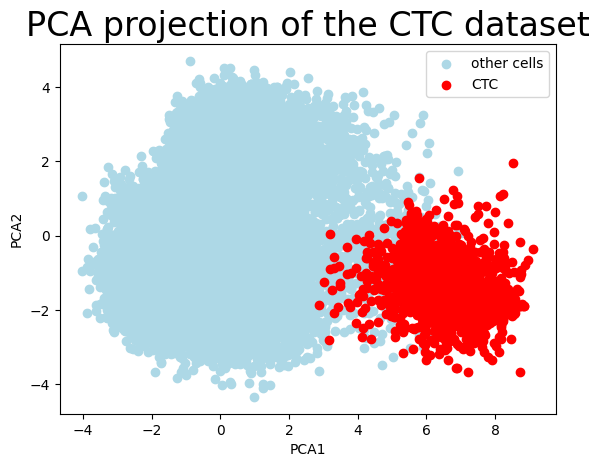

In [5]:
display_pca_2d_plot(cut_by_mean_max_train_data, data_object.train_classes, 42)

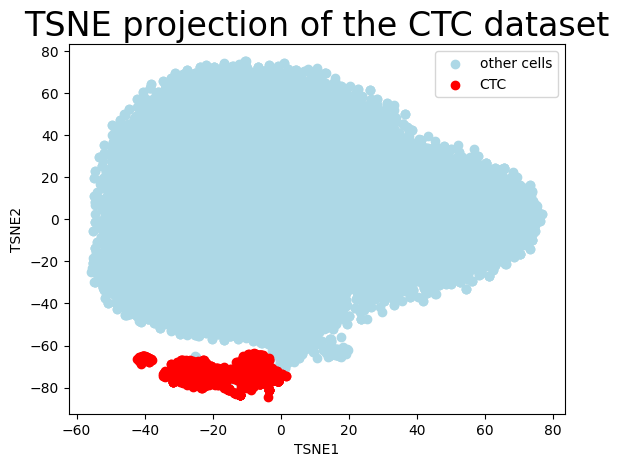

In [6]:
display_tsne_2d_plot(cut_by_mean_max_train_data, data_object.train_classes, 42)

In [7]:
cut_by_mean_with_classes_train_data, cut_by_mean_with_classes_test_data = data_object.cut_data_by_mean_with_classes(
    data_object.train_data, data_object.test_data, threshold=0.5
)
print(f"Feature number: {len(cut_by_mean_with_classes_train_data.columns)}")

Feature number: 59


In [8]:
calculate_global_statistics(cut_by_mean_with_classes_train_data, data_object.train_classes)

CTC mean: 0.783926484496173
WBC mean: 1.1376248675477092
CTC standard deviation: 1.1229087708081462
WBC standard deviation: 1.1082728238979702
CTC non-zero values: 47.14273086867169 %
WBC non-zero values: 54.12106186870236 %
T-test p-values: 0.0


/home/melehean/miniconda3/envs/gumed/lib/python3.8/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


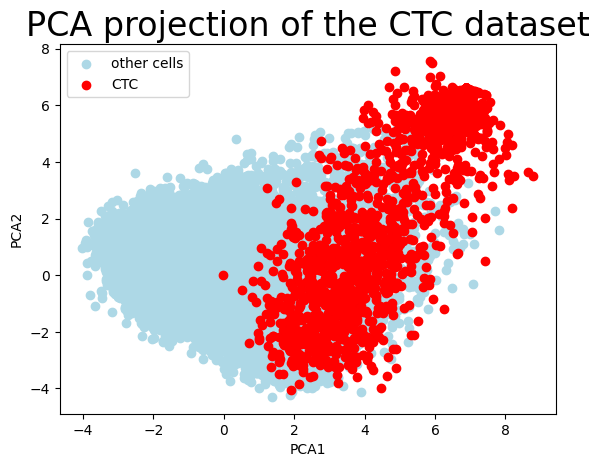

In [9]:
display_pca_2d_plot(cut_by_mean_with_classes_train_data, data_object.train_classes, 42)

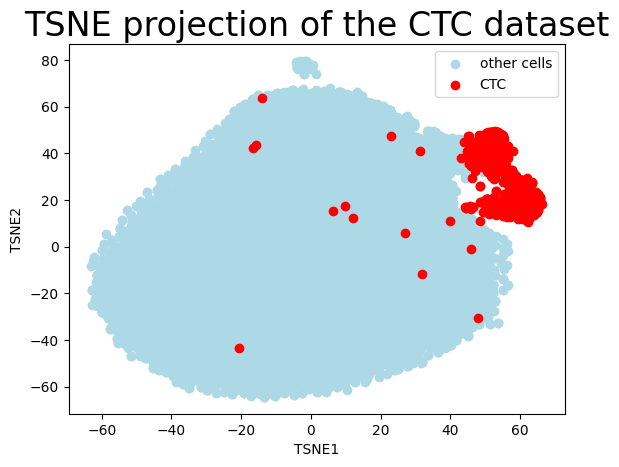

In [10]:
display_tsne_2d_plot(cut_by_mean_with_classes_train_data, data_object.train_classes, 42)

### LightGBM

In [11]:
lgbm_clf = LGBMClassifier(
    boosting_type="gbdt",
    min_child_weight=0.01,
    max_depth=10,
    num_leaves=16,
    n_estimators=2000,
    subsample_for_bin=10000,
    is_unbalance=True,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [12]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()


Validation balanced accuracy 0.9978458393428141
Training balanced accuracy 1.0

Validation roc auc 0.9999826418867966
Training roc auc 1.0

Validation precision 0.953255647484542
Training precision 1.0

Validation recall 0.9986966426125244
Training recall 1.0

Validation f1 0.9742640269172261
Training f1 1.0



In [13]:
lgbm_model_object.display_test_results()


Test balanced accuracy 0.8345857935229916

Test roc auc 0.8976710204568498

Test precision 0.9735890158343111

Test recall 0.7391304347826088

Test f1 score 0.8393596648443431


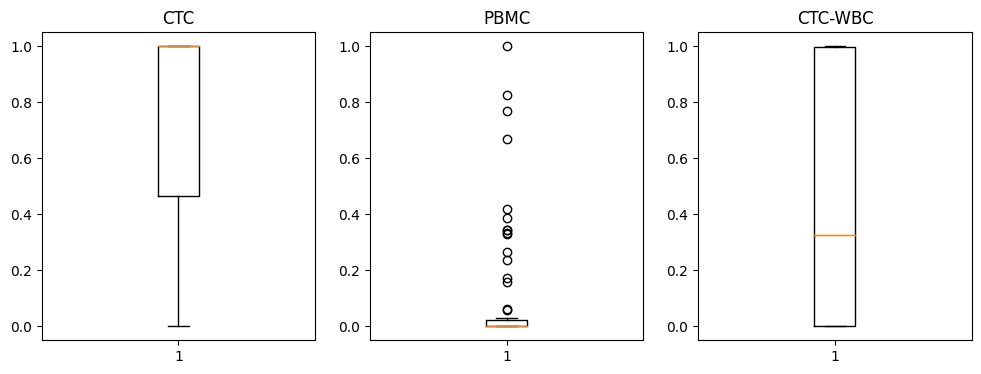

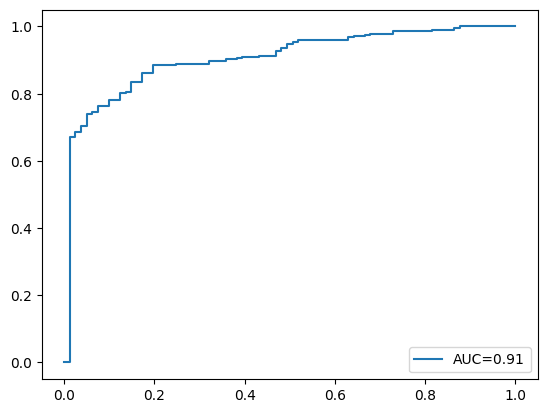

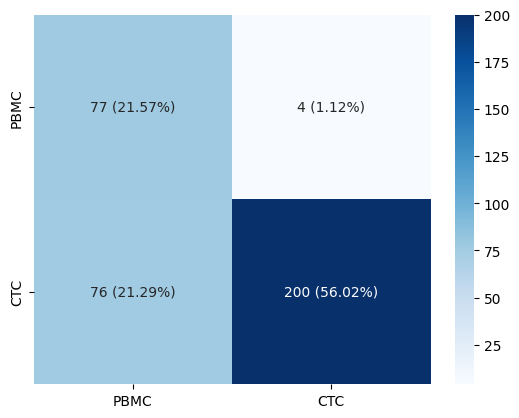

In [14]:
vis = Visualisation(lgbm_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [15]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 44


In [16]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9978458393428141
Training balanced accuracy 1.0

Validation roc auc 0.9999826418867966
Training roc auc 1.0

Validation precision 0.953255647484542
Training precision 1.0

Validation recall 0.9986966426125244
Training recall 1.0

Validation f1 0.9742640269172261
Training f1 1.0



In [17]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8345857935229916

Test roc auc 0.8976710204568498

Test precision 0.9735890158343111

Test recall 0.7391304347826088

Test f1 score 0.8393596648443431


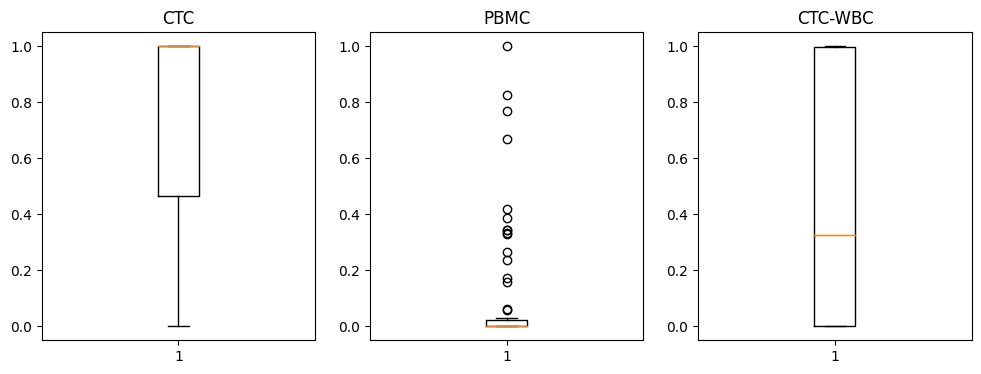

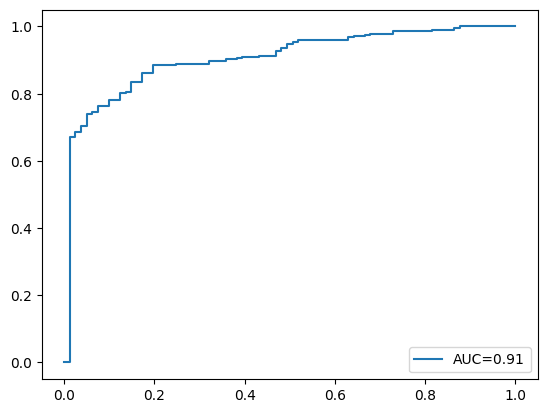

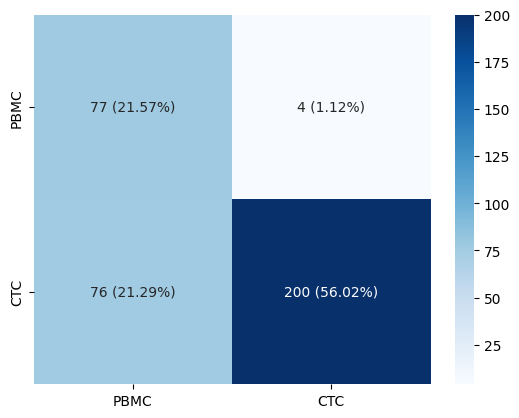

In [18]:
vis = Visualisation(lgbm_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### Cut by mean with classes

In [19]:
lgbm_model_object = Model(
    lgbm_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9961601052623915
Training balanced accuracy 1.0

Validation roc auc 0.9999858315733525
Training roc auc 1.0

Validation precision 0.9909061719006709
Training precision 1.0

Validation recall 0.9928270751793868
Training recall 1.0

Validation f1 0.9918481378528502
Training f1 1.0



In [20]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8286366076221148

Test roc auc 0.8868909166815769

Test precision 0.9643140957176279

Test recall 0.7560386473429951

Test f1 score 0.8461409761720331


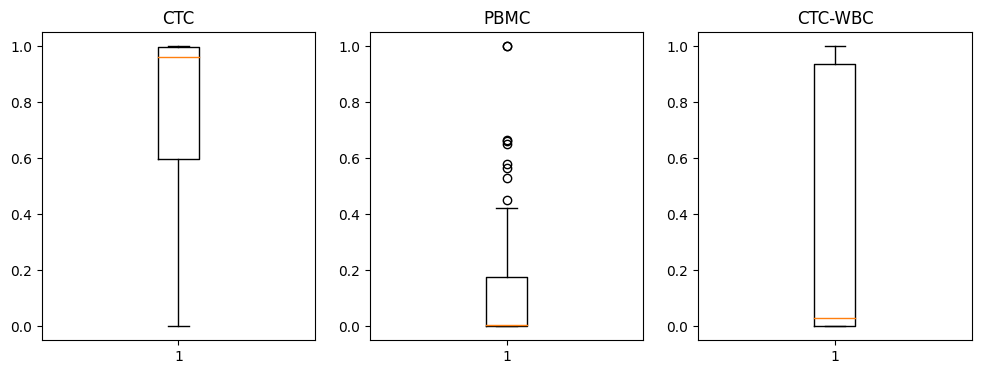

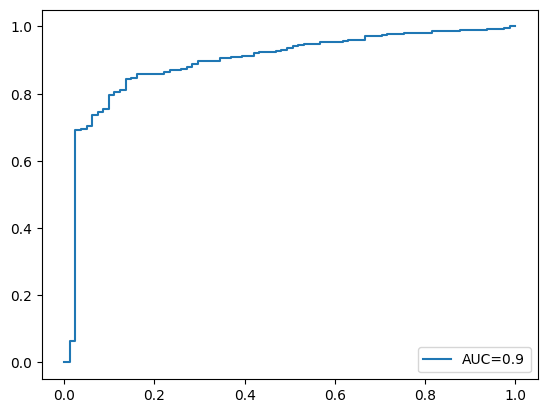

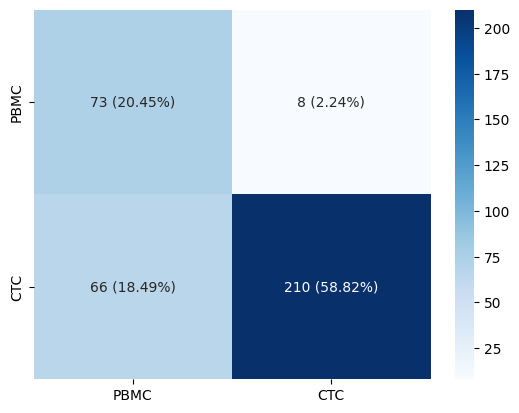

In [21]:
vis = Visualisation(lgbm_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [22]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(lgbm_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 59


In [23]:
lgbm_model_object = Model(
    lgbm_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
lgbm_estimators = lgbm_model_object.main_cycle()

Validation balanced accuracy 0.9961601052623915
Training balanced accuracy 1.0

Validation roc auc 0.9999858315733525
Training roc auc 1.0

Validation precision 0.9909061719006709
Training precision 1.0

Validation recall 0.9928270751793868
Training recall 1.0

Validation f1 0.9918481378528502
Training f1 1.0



In [24]:
lgbm_model_object.display_test_results()

Test balanced accuracy 0.8286366076221148

Test roc auc 0.8868909166815769

Test precision 0.9643140957176279

Test recall 0.7560386473429951

Test f1 score 0.8461409761720331


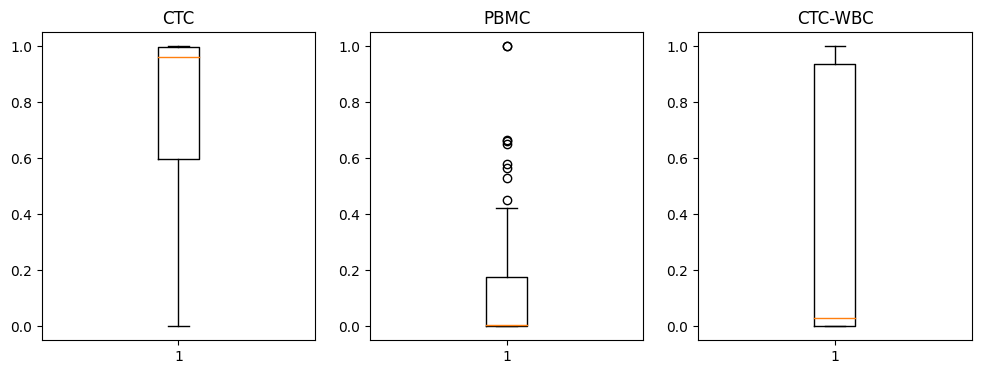

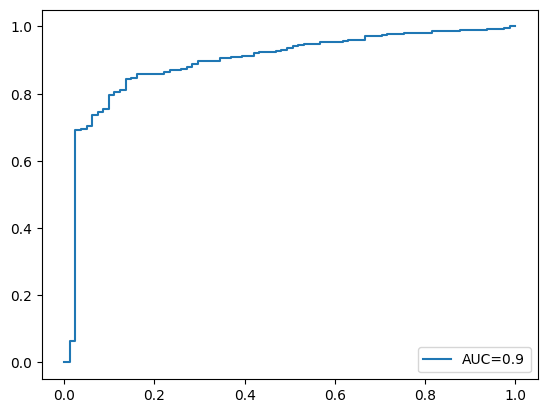

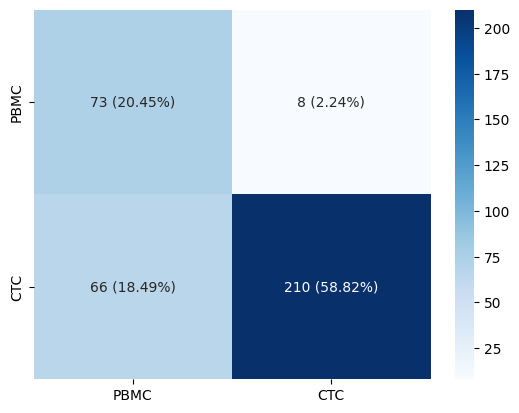

In [25]:
vis = Visualisation(lgbm_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### XGBoost

In [26]:
healthy_cells_train_indices = np.where(data_object.train_classes == 0)[0]
cancer_cells_train_indices = np.where(data_object.train_classes == 1)[0]

class_weight = len(healthy_cells_train_indices) / len(cancer_cells_train_indices)

xgb_clf = XGBClassifier(
    booster="gbtree",
    eta=0.2,
    min_child_weight=48,  # Jedyna zmiana w porownaniu do poprzedniego podzialu
    max_depth=8,
    gamma=0.01,   
    scale_pos_weight=class_weight,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [27]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9976463933529037
Training balanced accuracy 0.9989136804840409

Validation roc auc 0.9999213583574008
Training roc auc 0.999969800498722

Validation precision 0.9377225319020653
Training precision 0.967855100168769

Validation recall 0.9993476842791912
Training recall 0.9996738421395955

Validation f1 0.966081190972573
Training f1 0.983496468060999



In [28]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.7234746824118804

Test roc auc 0.8479602791196994

Test precision 0.9617998549667731

Test recall 0.5169082125603864

Test f1 score 0.672070446379481


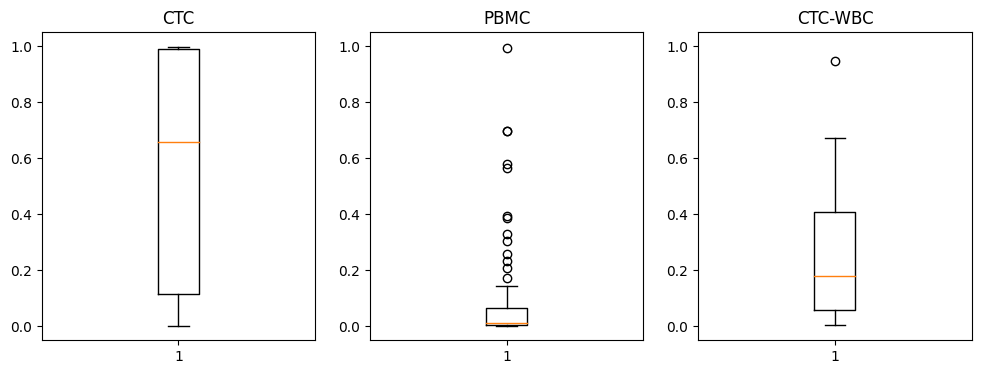

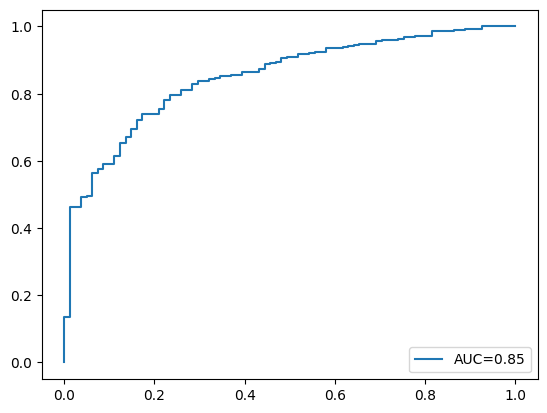

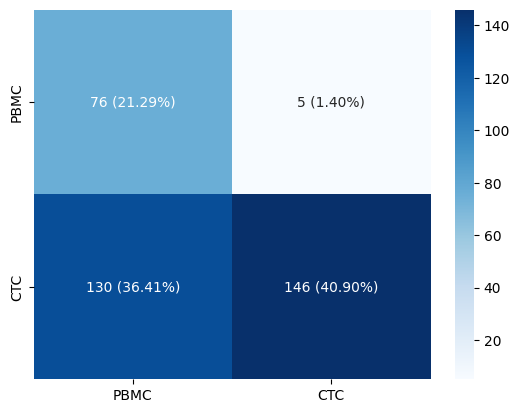

In [29]:
vis = Visualisation(xgboost_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [30]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 4


In [31]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9965589715815018
Training balanced accuracy 0.9979361525631832

Validation roc auc 0.9993301539245866
Training roc auc 0.9993945462128176

Validation precision 0.9599901337575979
Training precision 0.9519985276275937

Validation recall 0.99543506400848
Training recall 0.9986963250330462

Validation f1 0.9773386811850685
Training f1 0.9746696364498479



In [32]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.7348810162819825

Test roc auc 0.8292926581976502

Test precision 0.988020193665355

Test recall 0.4903381642512077

Test f1 score 0.6547405008144865


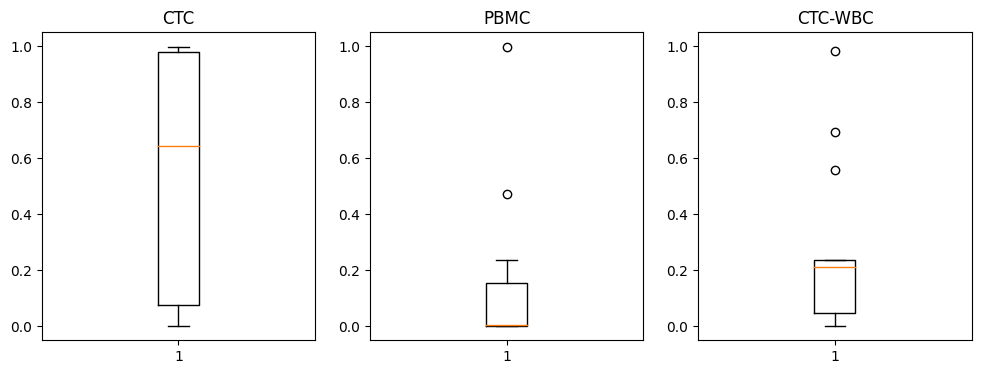

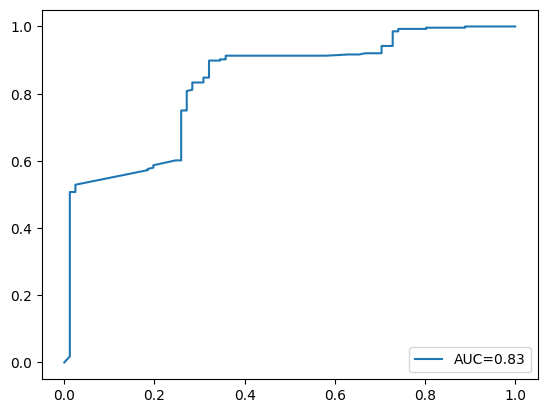

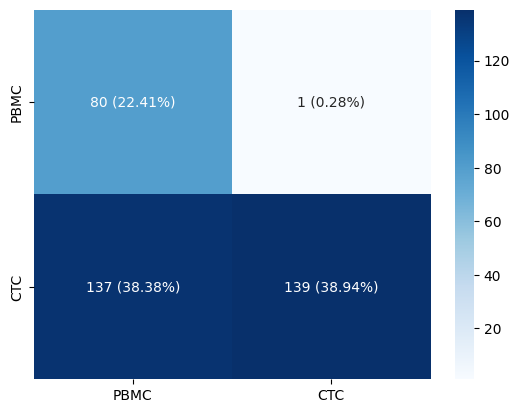

In [33]:
vis = Visualisation(xgboost_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### Cut by mean with classes

In [34]:
xgboost_model_object = Model(
    xgb_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9957440433697547
Training balanced accuracy 0.9987871119354602

Validation roc auc 0.9998916563975171
Training roc auc 0.9999810440892564

Validation precision 0.944292935259368
Training precision 0.9581529506205136

Validation recall 0.9947827482876712
Training recall 1.0

Validation f1 0.9687107354745859
Training f1 0.9786286911119788



In [35]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.8495705850778315

Test roc auc 0.9144152203733524

Test precision 0.9775905756179962

Test recall 0.7608695652173912

Test f1 score 0.8534241486236018


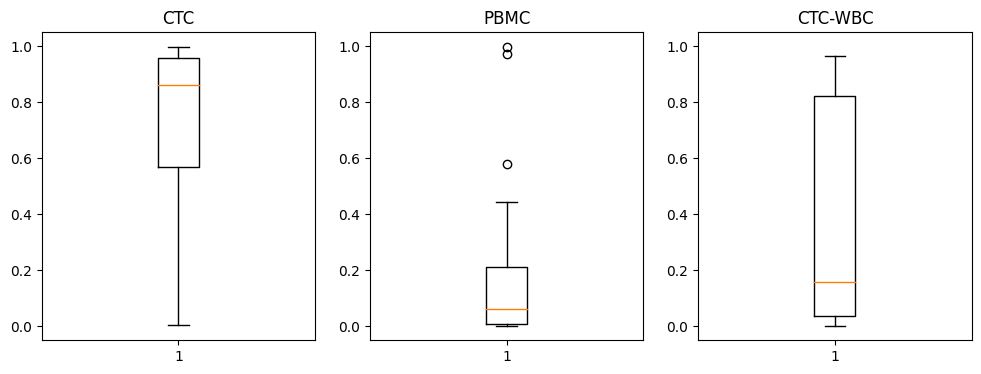

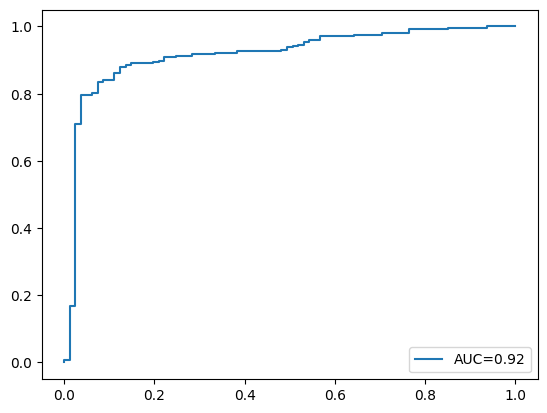

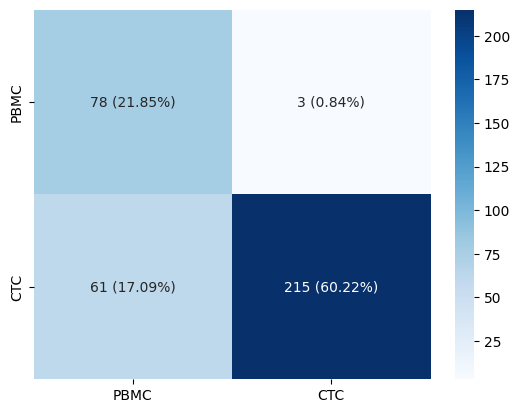

In [36]:
vis = Visualisation(xgboost_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [37]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(xgboost_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 7


In [38]:
xgboost_model_object = Model(
    xgb_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
xgboost_estimators = xgboost_model_object.main_cycle()

Validation balanced accuracy 0.9913959804282312
Training balanced accuracy 0.9980086985300108

Validation roc auc 0.9997390048211331
Training roc auc 0.9998846756542387

Validation precision 0.9201029322980542
Training precision 0.9332330859632517

Validation recall 0.9876072753587737
Training recall 1.0

Validation f1 0.9523810870893996
Training f1 0.9654254073043961



In [39]:
xgboost_model_object.display_test_results()

Test balanced accuracy 0.8017087135444623

Test roc auc 0.8964111051470148

Test precision 0.964624301137459

Test recall 0.6980676328502415

Test f1 score 0.7962683520299397


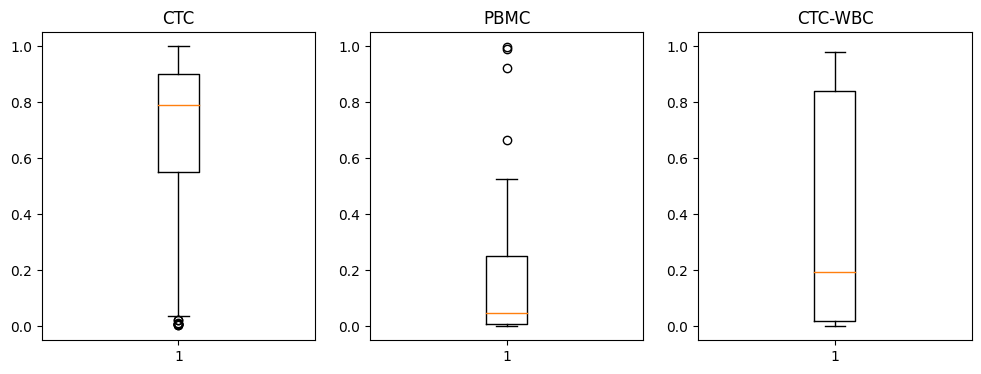

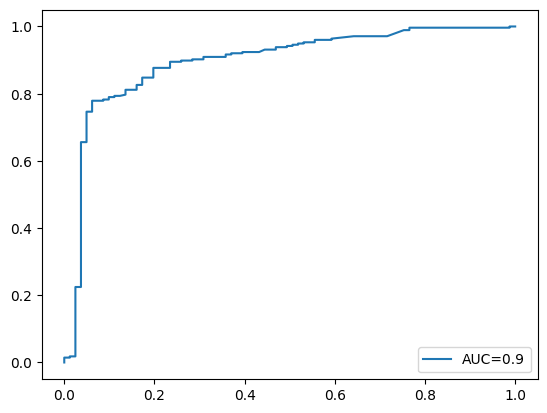

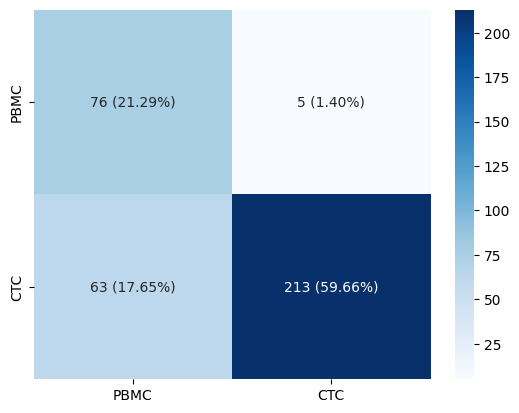

In [40]:
vis = Visualisation(xgboost_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### Random Forest

In [41]:
rf_clf = RandomForestClassifier(  
    criterion="log_loss",
    n_estimators=2000,
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [42]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9983701665499369
Training balanced accuracy 1.0

Validation roc auc 0.9999868573296177
Training roc auc 1.0

Validation precision 0.9885745537341974
Training precision 1.0

Validation recall 0.9973920111709068
Training recall 1.0

Validation f1 0.992914484266497
Training f1 1.0



In [43]:
rf_model_object.display_test_results()

Test balanced accuracy 0.618200930398998

Test roc auc 0.8395956342816246

Test precision 0.9669355830106338

Test recall 0.26932367149758457

Test f1 score 0.4190041578284484


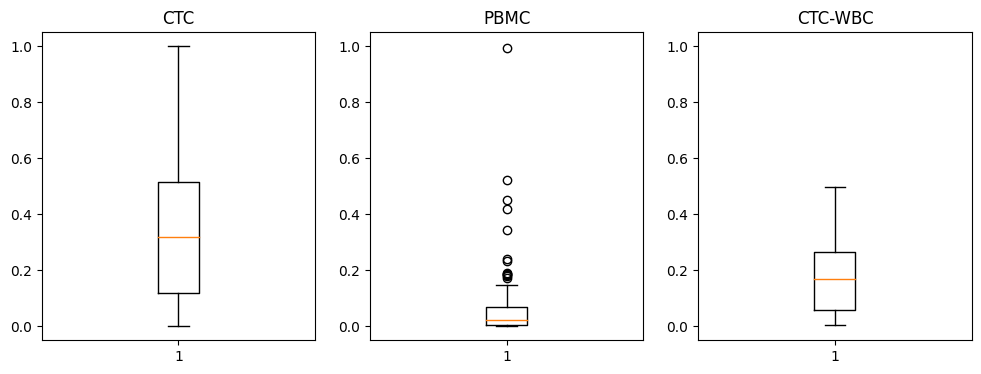

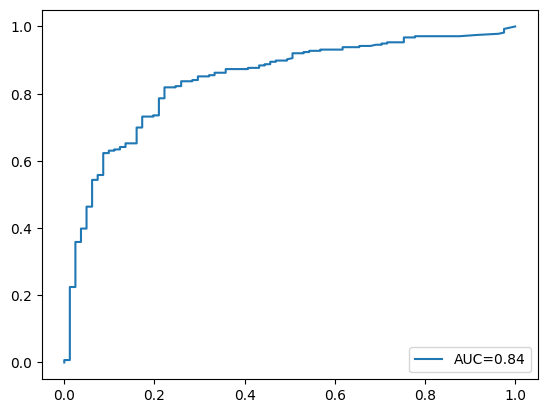

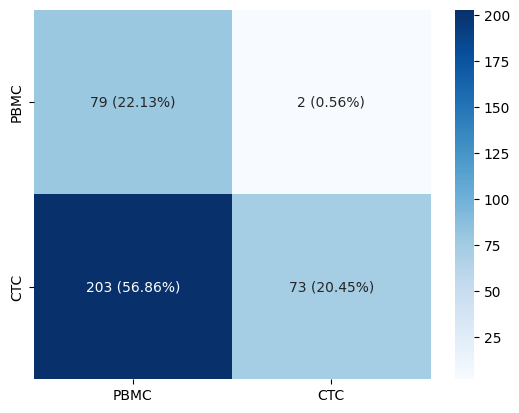

In [44]:
vis = Visualisation(rf_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [45]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 13


In [46]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9935041821644345
Training balanced accuracy 0.9999275893592029

Validation roc auc 0.9996121672362651
Training roc auc 0.9999720991081901

Validation precision 0.9891351391128755
Training precision 0.9974002751380766

Validation recall 0.9876238380626222
Training recall 1.0

Validation f1 0.98827219858181
Training f1 0.9986980754572036



In [47]:
rf_model_object.display_test_results()

Test balanced accuracy 0.6277509393451423

Test roc auc 0.8461412297966243

Test precision 0.976339522766494

Test recall 0.28019323671497587

Test f1 score 0.43371744361701325


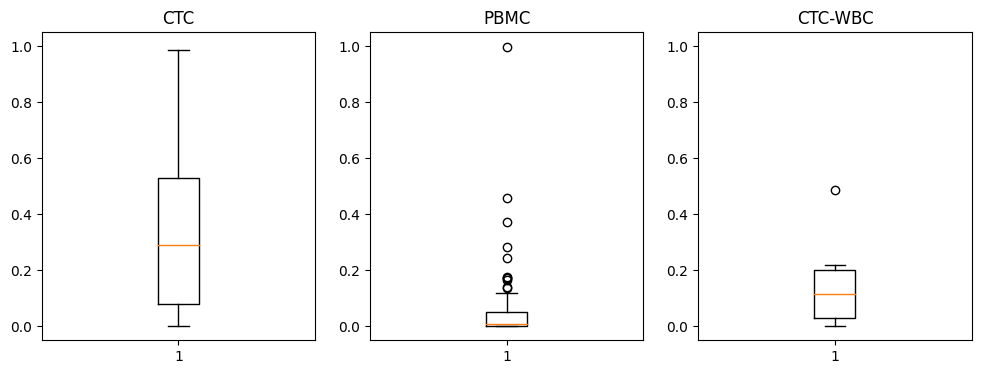

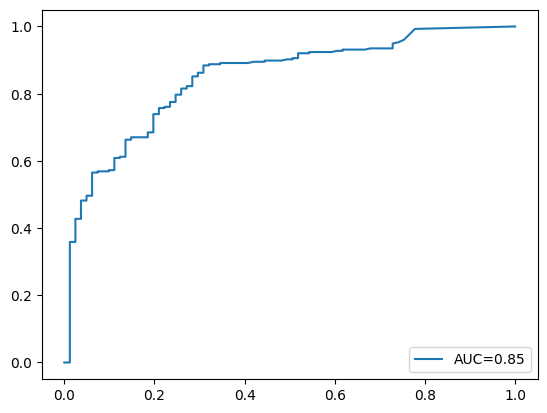

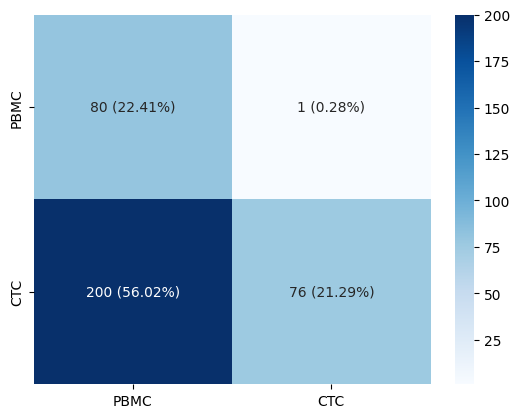

In [48]:
vis = Visualisation(rf_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### Cut by mean with classes

In [49]:
rf_model_object = Model(
    rf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9927184621675479
Training balanced accuracy 1.0

Validation roc auc 0.9999896572106127
Training roc auc 1.0

Validation precision 0.9960903533719069
Training precision 1.0

Validation recall 0.9856541503587737
Training recall 1.0

Validation f1 0.9907792780069954
Training f1 1.0



In [50]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8085077831454642

Test roc auc 0.8923704300113319

Test precision 0.9759196415063465

Test recall 0.678743961352657

Test f1 score 0.7968973669193772


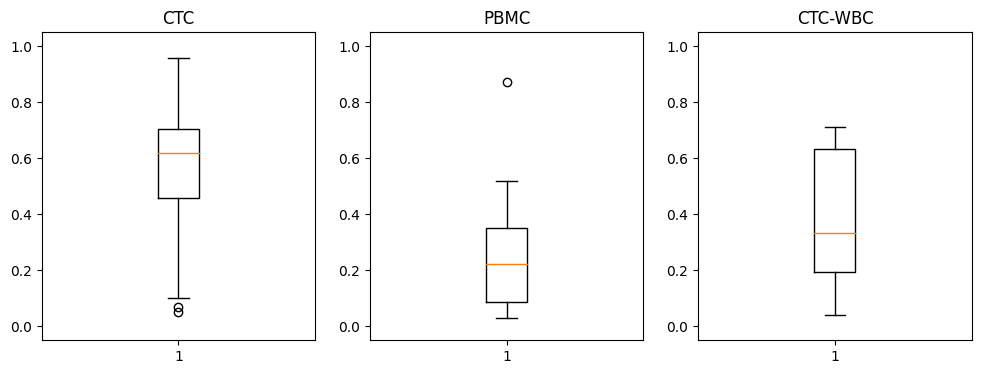

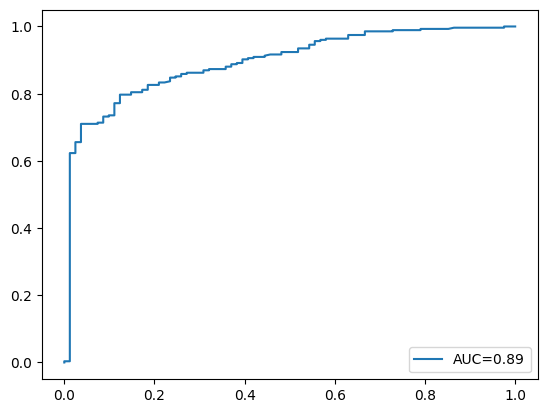

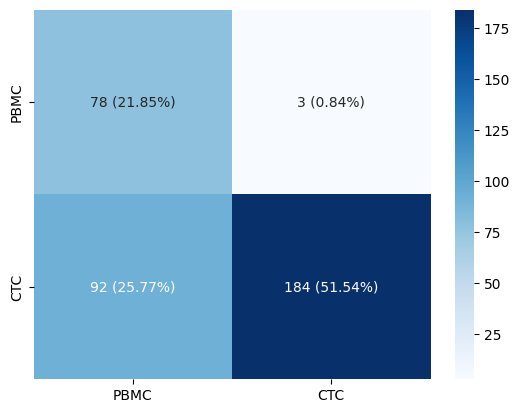

In [51]:
vis = Visualisation(rf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [52]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(rf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 16


In [53]:
rf_model_object = Model(
    rf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
rf_estimators = rf_model_object.main_cycle()

Validation balanced accuracy 0.9904728355361389
Training balanced accuracy 0.9999818973398007

Validation roc auc 0.9999534933955357
Training roc auc 0.9999880675600684

Validation precision 0.9973403550082468
Training precision 0.9993486401311502

Validation recall 0.9810904884213959
Training recall 1.0

Validation f1 0.9890869965558567
Training f1 0.9996741608866455



In [54]:
rf_model_object.display_test_results()

Test balanced accuracy 0.8013061370549291

Test roc auc 0.8902382656408422

Test precision 0.990179583557067

Test recall 0.6231884057971014

Test f1 score 0.7633610536778986


### Balanced Random Forest

In [55]:
brf_clf = BalancedRandomForestClassifier(
    n_estimators=2000,
    class_weight="balanced",
    criterion="entropy",
    oob_score=True,  
    n_jobs=12,
    random_state=SEED,
)

### Cut by mean + max data

In [56]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_max_train_data,
    data_object.train_classes,
    cut_by_mean_max_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.997592407638217
Training balanced accuracy 0.9989681449277258

Validation roc auc 0.9999573132820916
Training roc auc 0.9999983890297885

Validation precision 0.9280918366194125
Training precision 0.9642524767770588

Validation recall 1.0
Training recall 1.0

Validation f1 0.9607169292909554
Training f1 0.9817799421479251



In [57]:
brf_model_object.display_test_results()

Test balanced accuracy 0.6846484165324744

Test roc auc 0.8110797996063698

Test precision 0.93288768180373

Test recall 0.4927536231884058

Test f1 score 0.644285862275143


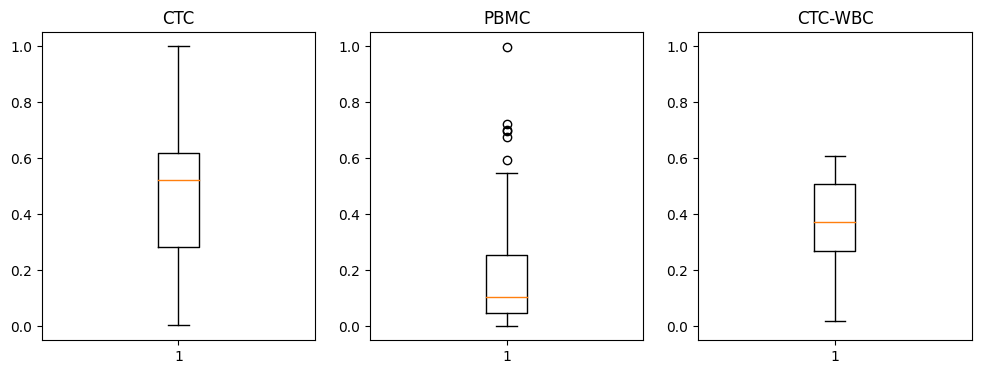

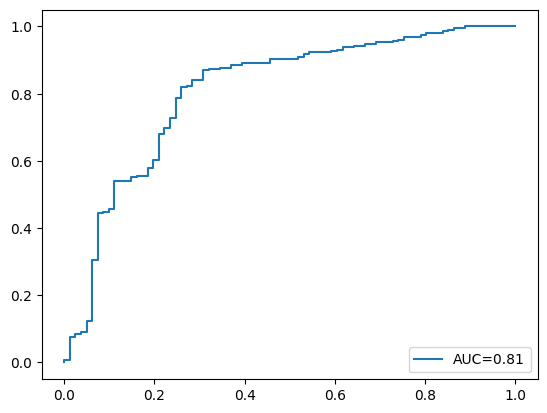

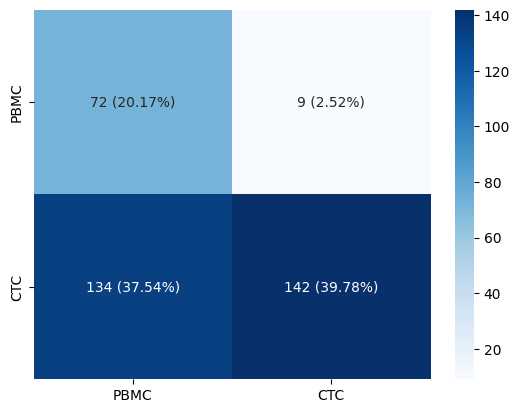

In [58]:
vis = Visualisation(brf_estimators, cut_by_mean_max_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [59]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_max_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 14


In [60]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9967768535747618
Training balanced accuracy 0.9989952967060072

Validation roc auc 0.9999148391141085
Training roc auc 0.9999611656825356

Validation precision 0.9316256494424269
Training precision 0.9651199149263748

Validation recall 0.9980430528375734
Training recall 1.0

Validation f1 0.962064645216516
Training f1 0.9822405616446113



In [61]:
brf_model_object.display_test_results()

Test balanced accuracy 0.6967480765789945

Test roc auc 0.8205105266296893

Test precision 0.94398073135737

Test recall 0.49637681159420294

Test f1 score 0.650167274660479


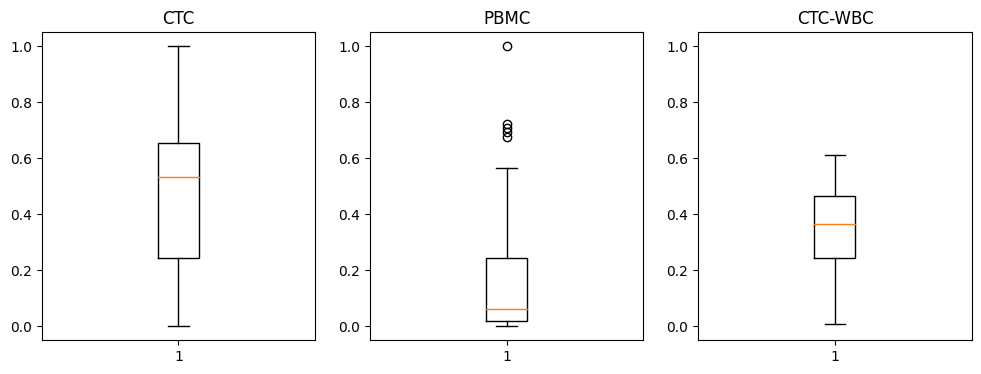

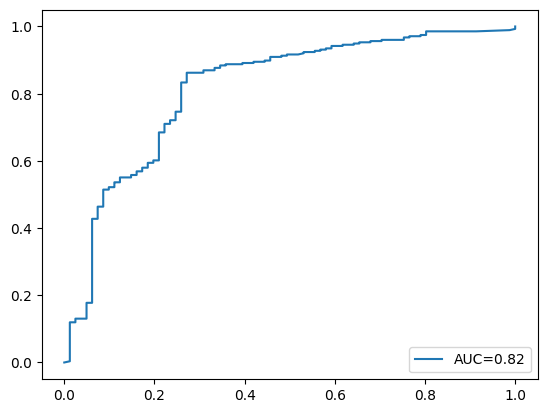

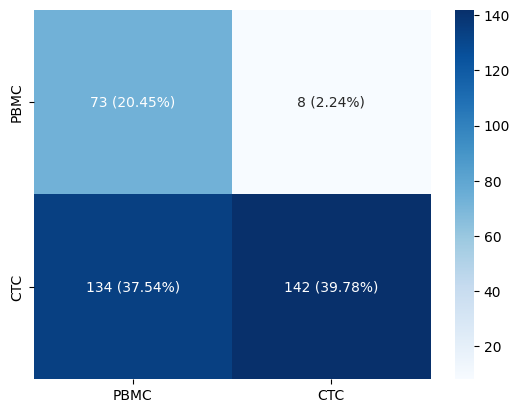

In [62]:
vis = Visualisation(brf_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

### Cut by mean with classes

In [63]:
brf_model_object = Model(
    brf_clf,
    cut_by_mean_with_classes_train_data,
    data_object.train_classes,
    cut_by_mean_with_classes_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9946045264822682
Training balanced accuracy 0.9974384487580518

Validation roc auc 0.9998427358620331
Training roc auc 0.9999983539972791

Validation precision 0.8712970627335892
Training precision 0.9156931074781317

Validation recall 0.9980430528375734
Training recall 1.0

Validation f1 0.9280856405134434
Training f1 0.9559538442458435



In [64]:
brf_model_object.display_test_results()

Test balanced accuracy 0.753913938092682

Test roc auc 0.8958892467346574

Test precision 0.887550510869064

Test recall 0.9070048309178743

Test f1 score 0.8960898796245589


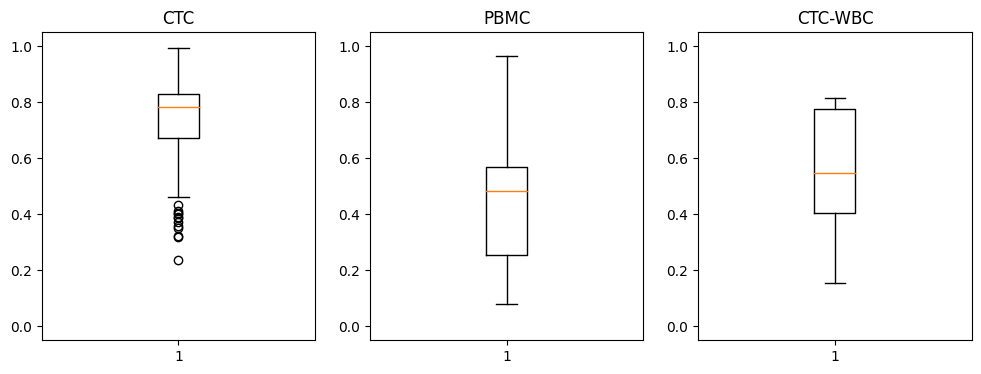

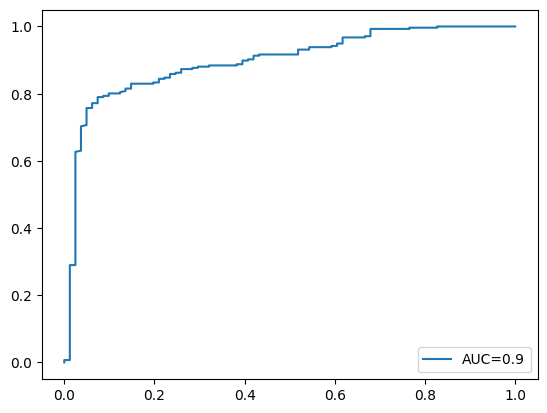

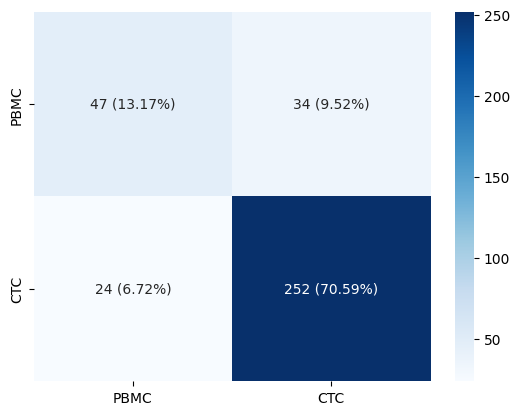

In [65]:
vis = Visualisation(brf_estimators, cut_by_mean_with_classes_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")

In [66]:
reduced_features = get_non_zero_feature_importance_of_tree_base_classifier(brf_estimators, cut_by_mean_with_classes_train_data)
reduced_train_data = data_object.train_data[reduced_features]
reduced_test_data = data_object.test_data[reduced_features]
print(f"Reduced feature number {len(reduced_features)}")

Reduced feature number 15


In [67]:
brf_model_object = Model(
    brf_clf,
    reduced_train_data,
    data_object.train_classes,
    reduced_test_data,
    data_object.test_classes,
    3,
)
brf_estimators = brf_model_object.main_cycle()

Validation balanced accuracy 0.9940966974876219
Training balanced accuracy 0.9971850149561782

Validation roc auc 0.9997920096977664
Training roc auc 0.9999729931148814

Validation precision 0.880039274122273
Training precision 0.9080370726791455

Validation recall 0.9960861056751468
Training recall 1.0

Validation f1 0.933151278396914
Training f1 0.9517817857396311



In [68]:
brf_model_object.display_test_results()

Test balanced accuracy 0.8073671497584541

Test roc auc 0.894331126617761

Test precision 0.9333212347572578

Test recall 0.8369565217391304

Test f1 score 0.8786594800164768


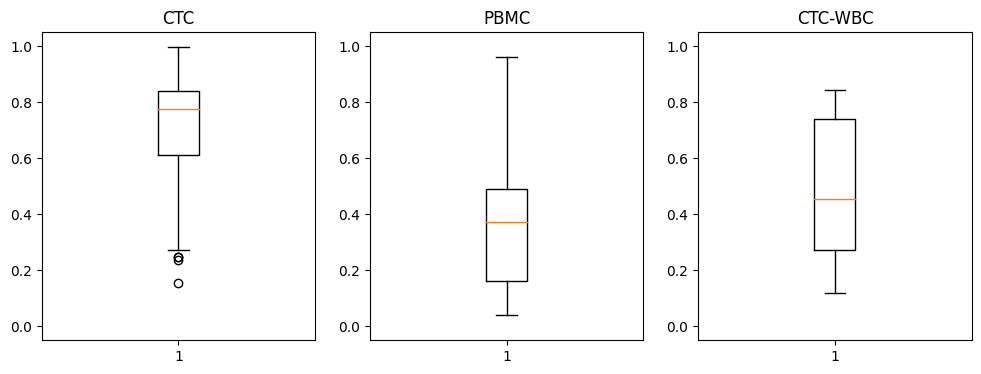

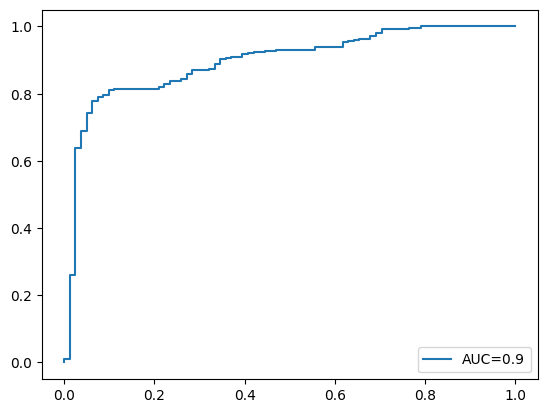

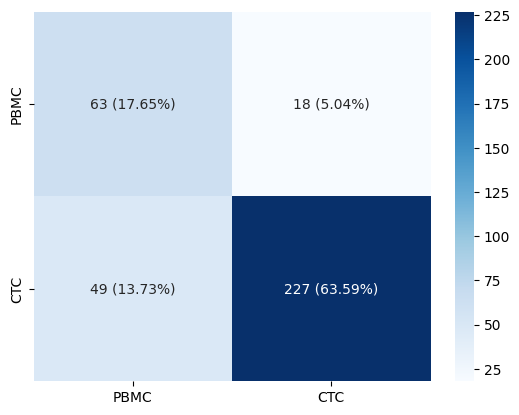

In [69]:
vis = Visualisation(brf_estimators, reduced_test_data, data_object.test_classes, data_object.test_classes_names)
vis.plot_predictions_boxplot(cancer_title="CTC", healthy_title="PBMC", mixed_title="CTC-WBC")
vis.draw_roc_curve_from_probabilities()
vis.display_confusion_matrix(cancer_category="CTC", healthy_category="PBMC")